In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(#locs=['jp'], #['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
    cats = ['business'],
    # business, entertainment, general, health, science, sports, technology
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [305]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='Digital Transformation at Khalifa Port: Data-Driven Insights')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 2679163#2494534#91220#1684065#6805333
print(ctx['seed'])
print(ctx['spark'])

5794194
Title: Websites of airlines, banks, tech companies back online after brief global outage - CNA
Description: Many websites were briefly down in an outage sparked by a glitch in Akamai Technologies's systems, the second major disruption linked to the cloud company in about a month.
Original Language: English


In [306]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Websites of airlines, banks, tech companies back online after brief global outage - CNA
Description: Many websites were briefly down in an outage sparked by a glitch in Akamai Technologies's systems, the second major disruption linked to the cloud company in about a month.
Original Language: English
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jar

In [307]:
##############################################
motivation_raw = '''
{
  "title": "Understanding the Impact of Global Internet Outages on Online Services",
  "introduction": "After reading about the recent global internet outages affecting airlines, banks, and tech companies, it's interesting to think about how often these disruptions occur and their scale. We could collect data on the frequency, duration, and sectors impacted by these outages over the past year. By examining this information, we might gain insights into the most affected services and the typical duration of such downtimes, offering a clearer picture of the digital landscape's stability."
}

'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [308]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [309]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''
[
  {
    "name": "Service Disruption Impact",
    "description": "Impact of service disruptions on companies' operations",
    "type": "outcome",
    "observed": true,
    "values": ["No Impact", "Significant Impact"],
    "parents": ["Cloud Service Reliability", "Company Preparedness", "Company Response Time"]
  },
  {
    "name": "Cloud Service Reliability",
    "description": "Reliability of cloud services provided by Akamai Technologies",
    "type": "treatment",
    "observed": true,
    "values": ["Unreliable", "Reliable"],
    "parents": ["Internet Traffic Volume"]
  },
  {
    "name": "Company Preparedness",
    "description": "Level of preparedness of companies for internet outages",
    "type": "treatment",
    "observed": true,
    "values": ["Unprepared", "Prepared"],
    "parents": ["Cybersecurity Threat Level"]
  },
  {
    "name": "Internet Traffic Volume",
    "description": "Volume of internet traffic at a given time",
    "type": "confounder",
    "observed": true,
    "values": ["Low Traffic", "High Traffic"],
    "parents": []
  },
  {
    "name": "Cybersecurity Threat Level",
    "description": "Current level of cybersecurity threats",
    "type": "confounder",
    "observed": true,
    "values": ["Low Threat", "High Threat"],
    "parents": []
  },
  {
    "name": "Company Response Time",
    "description": "Response time of companies to internet outages",
    "type": "mediator",
    "observed": true,
    "values": ["Slow Response", "Fast Response"],
    "parents": ["Internet Traffic Volume", "Cloud Service Reliability"]
  },
  {
    "name": "Customer Complaints",
    "description": "Number of customer complaints during outages",
    "type": "mediator",
    "observed": true,
    "values": ["Few Complaints", "Many Complaints"],
    "parents": ["Cybersecurity Threat Level", "Company Preparedness"]
  },
  {
    "name": "Public Perception",
    "description": "Public perception of companies following service disruptions",
    "type": "collider",
    "observed": true,
    "values": ["Negative Perception", "Positive Perception"],
    "parents": ["Service Disruption Impact", "Customer Complaints"]
  }
]

'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

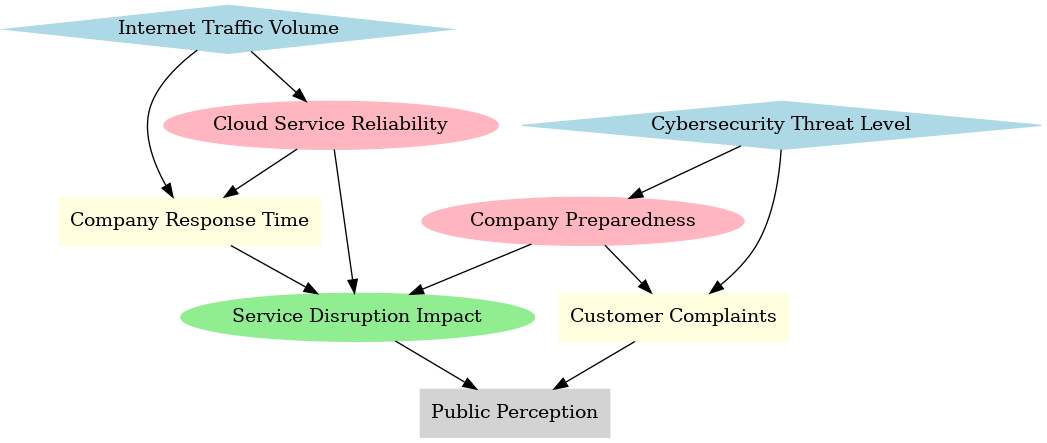

In [310]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [311]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

After reading about the recent global internet outages affecting airlines, banks, and tech companies, it's interesting to think about how often these disruptions occur and their scale. We could collect data on the frequency, duration, and sectors impacted by these outages over the past year. By examining this information, we might gain insights into the most affected services and the typical duration of such downtimes, offering a clearer picture of the digital landscape's stability.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (

In [312]:
#################################################

structure_raw = '''
[
	{"sentence": "The amount of internet traffic at any given time surprisingly influences both the reliability of cloud services and the speed at which companies respond to internet outages, highlighting a complex interaction between digital traffic and operational responses.", "involved": ["Internet Traffic Volume", "Cloud Service Reliability", "Company Response Time"]},
	{"sentence": "The current level of cybersecurity threats not only affects how well companies are prepared for internet outages but also plays a role in the number of customer complaints received during these outages.", "involved": ["Cybersecurity Threat Level", "Company Preparedness", "Customer Complaints"]},
	{"sentence": "Interestingly, the impact of service disruptions on companies' operations is determined not just by the reliability of cloud services and companies' preparedness, but also by how quickly companies can respond to these incidents.", "involved": ["Service Disruption Impact", "Cloud Service Reliability", "Company Preparedness", "Company Response Time"]},
	{"sentence": "Public perception of companies following service disruptions is shaped by both the severity of the service disruption's impact and the volume of customer complaints, indicating a direct link between operational issues and public sentiment.", "involved": ["Public Perception", "Service Disruption Impact", "Customer Complaints"]},
	{"sentence": "The reliability of cloud services is directly dependent on the volume of internet traffic, suggesting that higher traffic might lead to more challenges in maintaining service stability.", "involved": ["Cloud Service Reliability", "Internet Traffic Volume"]},
	{"sentence": "Companies' level of preparedness for internet outages is influenced by the current cybersecurity threat landscape, indicating that external security risks are a significant factor in operational readiness.", "involved": ["Company Preparedness", "Cybersecurity Threat Level"]}
]

'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [313]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

After reading about the recent global internet outages affecting airlines, banks, and tech companies, it's interesting to think about how often these disruptions occur and their scale. We could collect data on the frequency, duration, and sectors impacted by these outages over the past year. By examining this information, we might gain insights into the most affected services and the typical duration of such downtimes, offering a clearer picture of the digital landscape's stability.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Internet Traffic Volume" is "High Traffic" (rather than "Low Traffic")?
2. when "Internet Traffic Volume" is "Low Traffic": what is the probability that "Cloud Service Reliability" is "Reliable" (rather than "Unreliable")?
3. when "Internet Tra

In [314]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''
{
  "1": [0.5, 0.7],
  "2": [0.8, 0.95],
  "3": [0.4, 0.6],
  "4": [0.3, 0.5],
  "5": [0.7, 0.85],
  "6": [0.6, 0.75],
  "7": [0.6, 0.8],
  "8": [0.9, 0.95],
  "9": [0.4, 0.6],
  "10": [0.7, 0.85],
  "11": [0.7, 0.9],
  "12": [0.6, 0.75],
  "13": [0.6, 0.8],
  "14": [0.4, 0.6],
  "15": [0.5, 0.7],
  "16": [0.3, 0.5],
  "17": [0.2, 0.4],
  "18": [0.1, 0.3],
  "19": [0.6, 0.75],
  "20": [0.4, 0.6],
  "21": [0.75, 0.9],
  "22": [0.55, 0.7],
  "23": [0.8, 0.95],
  "24": [0.5, 0.7],
  "25": [0.4, 0.6],
  "26": [0.2, 0.4]
}

'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [315]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in ctx['nodes']})

def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, outcome, conditions=conditions).item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

-------------------------  ----------  ------------------  -------------------------------------------------------------
Cloud Service Reliability  Unreliable  Reliable            Reliability of cloud services provided by Akamai Technologies
Company Preparedness       Unprepared  Prepared            Level of preparedness of companies for internet outages
Service Disruption Impact  No Impact   Significant Impact  Impact of service disruptions on companies' operations
-------------------------  ----------  ------------------  -------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Internet Traffic Volume' means Volume of internet traffic at a given time
'Cloud Service Reliability' means Reliability of cloud services provided by Akamai Technologies
'Cybersecurity Threat Level' means Current level of cybersecurity threats
'Company Preparedness' means Level of preparedness of companies for internet outages
'Company Response Time' means Response time of companies to internet outages
'Service Disruption Impact' means Impact of service disruptions on companies' operations
'Customer Complaints' means Number of customer complaints during outages
'Public Perception' means Public perception of companies following service disruptions
Treatment Value    Treatment                  Outcome Value       Outcome                          ATE    Correlation
-----------------  -------------------------  ------------------  -------------------------  ---------  -------------
Reliable           Cloud Service Reliability  Significant Impact  Service Disruption Impact  -0.341595      

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                       ATE    Correlation  Outcome
--------------------------------------------  -----  -------------  --------------------------------------------
High Traffic Internet Traffic Volume          -0.28          -0.32  Reliable Cloud Service Reliability
High Traffic Internet Traffic Volume           0              0     High Threat Cybersecurity Threat Level
High Traffic Internet Traffic Volume           0              0     Prepared Company Preparedness
High Traffic Internet Traffic Volume          -0.27          -0.31  Fast Response Company Response Time
High Traffic Internet Traffic Volume           0.14           0.14  Significant Impact Service Disruption Impact
High Traffic Internet Traffic Volume           0              0     Many Complaints Customer Complaints
High Traffic Internet Traffic Volume          -0.04          -0.04  Positive Perception Public Perception
Reliable Cloud Service Reliability             0             -0.32  High Tra

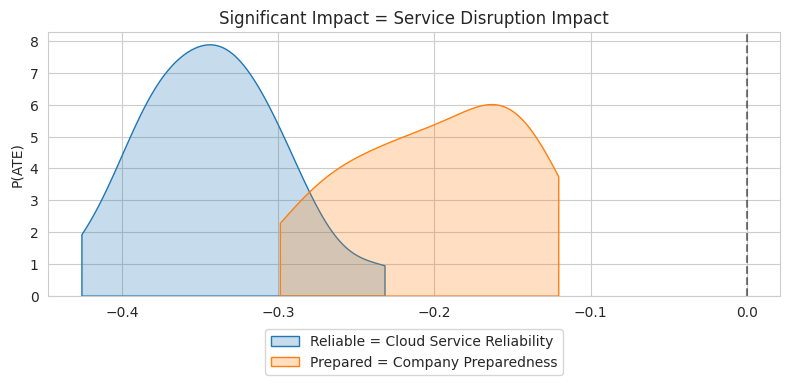

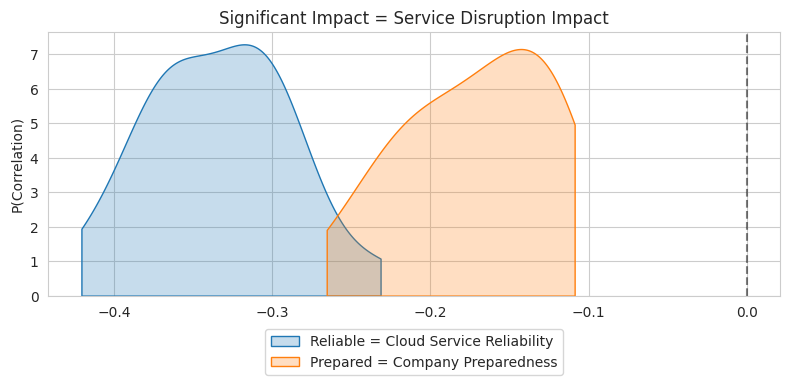

In [316]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
# assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
# assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'], node2['name']).item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

# print(net.backdoor_estimand(treatment1['name'], outcome['name']))
# print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [317]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Internet Traffic Volume' (0='Low Traffic', 1='High Traffic') means Volume of internet traffic at a given time
Variable 'Cloud Service Reliability' (0='Unreliable', 1='Reliable') means Reliability of cloud services provided by Akamai T

In [318]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''
{
  "Internet Traffic Volume": {
    "descriptor": ["the internet traffic volume", "the level of online activity"],
    "subject": "the digital highways",
    "predicate0": ["are not congested", "are experiencing light traffic"],
    "predicate1": ["are bustling with activity", "are heavily congested"],
    "pronoun": "they",
    "nounclause0": ["the internet traffic is low", "there's minimal online activity"],
    "nounclause1": ["the internet traffic is high", "there's a surge in online activity"],
    "preposition": ["during", "amidst"],
    "domain": "peak hours",
    "subclause0": ["online platforms experience smooth functioning", "users enjoy quick connectivity"],
    "subclause1": ["websites struggle to load", "users face slower connections"],
    "condition0": ["when the internet is quiet", "during periods of low online activity"],
    "condition1": ["when the digital world is buzzing", "during high internet traffic periods"],
    "action0": ["the internet traffic is reduced", "online activity decreases"],
    "action1": ["the internet traffic spikes", "there's an increase in online activity"]
  },
  "Cloud Service Reliability": {
    "descriptor": ["the reliability of cloud services", "cloud service stability"],
    "subject": "these cloud platforms",
    "predicate0": ["are not functioning optimally", "face frequent issues"],
    "predicate1": ["perform reliably", "maintain steady operations"],
    "pronoun": "they",
    "nounclause0": ["cloud services are experiencing issues", "there's instability in cloud operations"],
    "nounclause1": ["cloud services are stable", "cloud platforms are operating smoothly"],
    "preposition": ["in", "among"],
    "domain": "technology firms",
    "subclause0": ["technical difficulties are observed", "disruptions are common"],
    "subclause1": ["services run without hiccups", "operations are seamless"],
    "condition0": ["if the cloud service is unstable", "when cloud platforms are unreliable"],
    "condition1": ["if the cloud service is reliable", "when cloud platforms are dependable"],
    "action0": ["a cloud service becomes unstable", "there are disruptions in cloud operations"],
    "action1": ["a cloud service maintains reliability", "cloud operations run smoothly"]
  },
  "Cybersecurity Threat Level": {
    "descriptor": ["the level of cybersecurity threats", "the cybersecurity risk"],
    "subject": "the digital landscape",
    "predicate0": ["is relatively safe", "experiences few security threats"],
    "predicate1": ["faces significant risks", "is under constant threat"],
    "pronoun": "it",
    "nounclause0": ["cybersecurity threats are minimal", "digital security risks are low"],
    "nounclause1": ["cybersecurity threats are rampant", "there's a high risk of cyber attacks"],
    "preposition": ["with", "under"],
    "domain": "the current security climate",
    "subclause0": ["online users feel secure", "security measures are less strained"],
    "subclause1": ["security teams are on high alert", "vigilance against cyber attacks is critical"],
    "condition0": ["when cybersecurity threats are low", "if digital security risks are minimal"],
    "condition1": ["when facing high cybersecurity threats", "under severe cyber threat conditions"],
    "action0": ["cybersecurity threats decrease", "digital security risks are mitigated"],
    "action1": ["cybersecurity threats escalate", "the risk of cyber attacks increases"]
  },
  "Company Preparedness": {
    "descriptor": ["the preparedness of companies", "corporate readiness for outages"],
    "subject": "these organizations",
    "predicate0": ["are not fully equipped", "lack contingency plans"],
    "predicate1": ["are well-prepared", "have robust contingency measures"],
    "pronoun": "they",
    "nounclause0": ["companies are unprepared for disruptions", "there's a lack of readiness in corporations"],
    "nounclause1": ["companies are geared up for any issues", "corporate preparedness is high"],
    "preposition": ["among", "within"],
    "domain": "the business sector",
    "subclause0": ["firms find themselves scrambling", "contingency plans are lacking"],
    "subclause1": ["businesses manage disruptions effectively", "emergency protocols are in place"],
    "condition0": ["if a company is unprepared", "when businesses lack contingency plans"],
    "condition1": ["if a company is well-prepared", "when businesses have robust emergency measures"],
    "action0": ["a company neglects preparedness", "contingency planning is overlooked"],
    "action1": ["a company enhances its preparedness", "emergency protocols are established"]
  },
  "Company Response Time": {
    "descriptor": ["the response time of companies", "how quickly companies react"],
    "subject": "these firms",
    "predicate0": ["are slow to react", "take longer to respond"],
    "predicate1": ["respond swiftly", "act promptly"],
    "pronoun": "they",
    "nounclause0": ["company response is delayed", "there's a lag in corporate reaction"],
    "nounclause1": ["companies respond in no time", "a quick corporate reaction is observed"],
    "preposition": ["in", "during"],
    "domain": "crisis situations",
    "subclause0": ["delays in addressing issues are seen", "the reaction time is prolonged"],
    "subclause1": ["immediate action is taken", "issues are addressed without delay"],
    "condition0": ["when a company's response is slow", "if there's a delay in corporate reaction"],
    "condition1": ["when companies react swiftly", "if corporate action is immediate"],
    "action0": ["response time is delayed", "corporate reaction is slow"],
    "action1": ["response time is quickened", "corporate reaction is prompt"]
  },
  "Service Disruption Impact": {
    "descriptor": ["the impact of service disruptions", "the effect of outages on operations"],
    "subject": "these service interruptions",
    "predicate0": ["do not significantly affect operations", "have minimal impact"],
    "predicate1": ["cause major operational issues", "have a significant effect"],
    "pronoun": "they",
    "nounclause0": ["service disruptions are barely noticeable", "the impact on operations is negligible"],
    "nounclause1": ["service disruptions lead to major issues", "operations are significantly affected"],
    "preposition": ["on", "for"],
    "domain": "businesses",
    "subclause0": ["operations continue smoothly", "there's hardly any effect on daily functions"],
    "subclause1": ["business activities face severe disruption", "operational challenges are evident"],
    "condition0": ["if service disruptions are minor", "when outages have little impact"],
    "condition1": ["if service disruptions are severe", "when outages cause major issues"],
    "action0": ["service disruptions are minimized", "outages have little effect"],
    "action1": ["service disruptions are extensive", "outages cause significant operational issues"]
  },
  "Customer Complaints": {
    "descriptor": ["the number of customer complaints", "customer feedback during outages"],
    "subject": "customers",
    "predicate0": ["are mostly content", "express few grievances"],
    "predicate1": ["voice numerous complaints", "are highly dissatisfied"],
    "pronoun": "they",
    "nounclause0": ["there are few customer complaints", "customer feedback is mostly positive"],
    "nounclause1": ["customer complaints are rampant", "there's a surge in negative feedback"],
    "preposition": ["amidst", "during"],
    "domain": "service outages",
    "subclause0": ["complaints are minimal", "satisfaction levels are maintained"],
    "subclause1": ["complaints skyrocket", "dissatisfaction becomes evident"],
    "condition0": ["when customers are mostly satisfied", "if there are few complaints"],
    "condition1": ["when customers are highly dissatisfied", "if there's a wave of complaints"],
    "action0": ["complaints are reduced", "customer satisfaction improves"],
    "action1": ["complaints increase", "customer dissatisfaction grows"]
  },
  "Public Perception": {
    "descriptor": ["the public's view of companies", "how the public sees these companies", "public sentiment towards companies"],
    "subject": "the public's opinion",
    "predicate0": ["is critical of companies", "leans negative", "is unfavorable"],
    "predicate1": ["is favorable towards companies", "is positive", "supports companies"],
    "pronoun": "it",
    "nounclause0": ["the public's opinion is critical", "public sentiment is unfavorable", "the public view is negative"],
    "nounclause1": ["the public's opinion is favorable", "public sentiment is positive", "the public view is supportive"],
    "preposition": ["among", "within"],
    "domain": "the public",
    "subclause0": ["the perception is critical of the companies", "there is negative sentiment towards the companies"],
    "subclause1": ["the perception is supportive of the companies", "there is a positive sentiment towards the companies"],
    "condition0": ["when the public views companies negatively", "if public opinion is unfavorable"],
    "condition1": ["when the public views companies favorably", "if public opinion is positive"],
    "action0": ["public opinion shifts to negative", "there is a turn towards unfavorable sentiment"],
    "action1": ["public opinion shifts to positive", "there is a turn towards supportive sentiment"]
  }
}
'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [319]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

After reading about the recent global internet outages affecting airlines, banks, and tech companies, it's interesting to think about how often these disruptions occur and their scale. We could collect data on the frequency, duration, and sectors impacted by these outages over the past year. By examining this information, we might gain insights into the most affected services and the typical duration of such downtimes, offering a clearer picture of the digital landscape's stability.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Cloud Service Reliability') > 0
	2. ATE('Company Preparedness') > 0
	3. ATE('Cloud Service Reliability') > ATE('Company Preparedness')
	4. |ATE('Cloud Service Reliability')| < |ATE('Company Preparedness')|
	5. CATE('Cloud S

In [320]:
# setting = ctx['questions']
#################################################
settings_raw = '''
{
    "1": {"question": "Does improving cloud service reliability generally lead to a decrease in service disruption impact?", "answer": "yes", "claim": "Enhancing cloud service reliability typically reduces the impact of service disruptions."},
    "2": {"question": "Is there a general benefit in company preparedness for reducing service disruption impact?", "answer": "yes", "claim": "Generally, better company preparedness helps in mitigating the impact of service disruptions."},
    "3": {"question": "Is improving cloud service reliability more effective than enhancing company preparedness in reducing service disruption impact?", "answer": "yes", "claim": "Improving cloud service reliability is more effective than enhancing company preparedness in reducing the impact of service disruptions."},
    "4": {"question": "Is the impact of company preparedness on service disruptions more variable than that of cloud service reliability?", "answer": "yes", "claim": "The effect of company preparedness on service disruptions varies more than the impact of cloud service reliability."},
    "5": {"question": "Does high reliability in cloud services reduce service disruption impact more when internet traffic is low?", "answer": "no", "claim": "High cloud service reliability does not reduce service disruption impact more significantly when internet traffic is low."},
    "6": {"question": "Does high company preparedness reduce service disruption impact more when internet traffic is low?", "answer": "yes", "claim": "High company preparedness reduces the impact of service disruptions more effectively when internet traffic is low."},
    "7": {"question": "Is company preparedness more effective than cloud service reliability in reducing service disruption impact when internet traffic is low?", "answer": "no", "claim": "Company preparedness is not more effective than cloud service reliability in reducing the impact of service disruptions when internet traffic is low."},
    "8": {"question": "Does the effectiveness of company preparedness in reducing service disruption impact vary more than cloud service reliability when internet traffic is low?", "answer": "yes", "claim": "The variability in effectiveness of company preparedness in reducing service disruptions is greater than that of cloud service reliability when internet traffic is low."},
    "9": {"question": "Does high reliability in cloud services reduce service disruption impact less when internet traffic is high?", "answer": "no", "claim": "High cloud service reliability does not reduce the impact of service disruptions less significantly when internet traffic is high."},
    "10": {"question": "Does high company preparedness reduce service disruption impact less when internet traffic is high?", "answer": "no", "claim": "High company preparedness does not reduce the impact of service disruptions less significantly when internet traffic is high."},
    "11": {"question": "Is improving cloud service reliability more effective than enhancing company preparedness in reducing service disruption impact when internet traffic is high?", "answer": "yes", "claim": "Improving cloud service reliability is more effective than enhancing company preparedness in reducing the impact of service disruptions when internet traffic is high."},
    "12": {"question": "Does the effectiveness of cloud service reliability in reducing service disruption impact vary less than company preparedness when internet traffic is high?", "answer": "no", "claim": "The variability in effectiveness of cloud service reliability in reducing service disruptions does not vary less than that of company preparedness when internet traffic is high."},
    "13": {"question": "Is the effect of cloud service reliability on reducing service disruption impact greater when internet traffic is high compared to when it is low?", "answer": "yes", "claim": "The effect of cloud service reliability on reducing service disruptions is greater when internet traffic is high compared to when it is low."},
    "14": {"question": "Does the effectiveness of cloud service reliability in reducing service disruption impact vary more when internet traffic is low than when it is high?", "answer": "yes", "claim": "The variability in effectiveness of cloud service reliability in reducing service disruptions is greater when internet traffic is low than when it is high."},
    "15": {"question": "Is the effect of company preparedness on reducing service disruption impact greater when internet traffic is low compared to when it is high?", "answer": "yes", "claim": "The effect of company preparedness on reducing service disruptions is greater when internet traffic is low compared to when it is high."},
    "16": {"question": "Does the effectiveness of company preparedness in reducing service disruption impact vary more when internet traffic is low than when it is high?", "answer": "yes", "claim": "The variability in effectiveness of company preparedness in reducing service disruptions is greater when internet traffic is low than when it is high."},
    "17": {"question": "Does improving cloud service reliability generally lead to a decrease in service disruption impact when cybersecurity threats are low?", "answer": "yes", "claim": "Enhancing cloud service reliability typically reduces the impact of service disruptions when cybersecurity threats are low."},
    "18": {"question": "Is there a general benefit in company preparedness for reducing service disruption impact when cybersecurity threats are low?", "answer": "yes", "claim": "Generally, better company preparedness helps in mitigating the impact of service disruptions when cybersecurity threats are low."},
    "19": {"question": "Is company preparedness more effective than cloud service reliability in reducing service disruption impact when cybersecurity threats are low?", "answer": "no", "claim": "Company preparedness is not more effective than cloud service reliability in reducing the impact of service disruptions when cybersecurity threats are low."},
    "20": {"question": "Does the impact of company preparedness on service disruptions vary more than that of cloud service reliability when cybersecurity threats are low?", "answer": "no", "claim": "The effect of company preparedness on service disruptions does not vary more than the impact of cloud service reliability when cybersecurity threats are low."},
    "21": {"question": "Does improving cloud service reliability generally lead to a decrease in service disruption impact when cybersecurity threats are high?", "answer": "no", "claim": "Enhancing cloud service reliability does not typically reduce the impact of service disruptions when cybersecurity threats are high."},
    "22": {"question": "Is there a general benefit in company preparedness for reducing service disruption impact when cybersecurity threats are high?", "answer": "no", "claim": "Generally, better company preparedness does not help in mitigating the impact of service disruptions when cybersecurity threats are high."},
    "23": {"question": "Is company preparedness more effective than cloud service reliability in reducing service disruption impact when cybersecurity threats are high?", "answer": "yes", "claim": "Company preparedness is more effective than cloud service reliability in reducing the impact of service disruptions when cybersecurity threats are high."},
    "24": {"question": "Does the effectiveness of company preparedness in reducing service disruption impact vary more than cloud service reliability when cybersecurity threats are high?", "answer": "yes", "claim": "The variability in effectiveness of company preparedness in reducing service disruptions is greater than that of cloud service reliability when cybersecurity threats are high."},
    "25": {"question": "Is the effect of cloud service reliability on reducing service disruption impact greater when cybersecurity threats are high compared to when they are low?", "answer": "no", "claim": "The effect of cloud service reliability on reducing service disruptions is not greater when cybersecurity threats are high compared to when they are low."},
    "26": {"question": "Does the effectiveness of cloud service reliability in reducing service disruption impact vary less when cybersecurity threats are high than when they are low?", "answer": "no", "claim": "The variability in effectiveness of cloud service reliability in reducing service disruptions does not vary less when cybersecurity threats are high than when they are low."},
    "27": {"question": "Is the effect of company preparedness on reducing service disruption impact greater when cybersecurity threats are high compared to when they are low?", "answer": "yes", "claim": "The effect of company preparedness on reducing service disruptions is greater when cybersecurity threats are high compared to when they are low."},
    "28": {"question": "Does the effectiveness of company preparedness in reducing service disruption impact vary less when cybersecurity threats are high than when they are low?", "answer": "no", "claim": "The variability in effectiveness of company preparedness in reducing service disruptions does not vary less when cybersecurity threats are high than when they are low."}
}

'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [321]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Understanding the Impact of Global Internet Outages on Online Services.json'